In [6]:
# ============================================================================
# CELL 1: Import Required Libraries and Load Data
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings

warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define paths
OUTPUT_PATH = r"f:\BRACU\Semester 12 Final\CSE425\FInal_project\processed_data"
RESULTS_PATH = r"f:\BRACU\Semester 12 Final\CSE425\FInal_project\results"
os.makedirs(RESULTS_PATH, exist_ok=True)

# Load preprocessed data
print("Loading preprocessed data...")
features = np.load(os.path.join(OUTPUT_PATH, 'features_normalized.npy'))
labels = np.load(os.path.join(OUTPUT_PATH, 'labels.npy'), allow_pickle=True)
metadata = pd.read_csv(os.path.join(OUTPUT_PATH, 'metadata.csv'))

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(f"Data loaded: {features.shape[0]} samples, {features.shape[1]} features")

Using device: cuda
Loading preprocessed data...
Data loaded: 1859 samples, 370 features


In [7]:
class VAE(nn.Module):
    """Variational Autoencoder for music feature extraction."""
    
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], latent_dim=64):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder: input_dim -> 512 -> 256 -> 128 -> latent_dim
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder: latent_dim -> 128 -> 256 -> 512 -> input_dim
        decoder_layers = []
        hidden_dims_rev = hidden_dims[::-1]  # [128, 256, 512]
        prev_dim = latent_dim
        for hidden_dim in hidden_dims_rev:
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(hidden_dims_rev[-1], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z
    
    def get_latent_features(self, x):
        mu, _ = self.encode(x)
        return mu

def vae_loss(reconstruction, x, mu, logvar, beta=0.8):

    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(reconstruction, x, reduction='mean')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

In [15]:
VAE_CONFIG = {
    'hidden_dims': [128, 64, 32],   # Hidden layer dimensions
    'latent_dim': 32,                 # Latent space dimension
    'learning_rate': 1e-4,
    'batch_size': 32,
    'epochs': 500,
    'beta': 0.1,                      # KL divergence weight
    'patience': 15,                   # Early stopping patience
}

print("VAE Configuration:")
for key, value in VAE_CONFIG.items():
    print(f"  {key}: {value}")
# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(features)

# Create DataLoader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(
    dataset, 
    batch_size=VAE_CONFIG['batch_size'], 
    shuffle=True
)

# print(f"\nDataLoader created with {len(dataloader)} batches")
# Initialize VAE
input_dim = features.shape[1]
vae = VAE(
    input_dim=input_dim,
    hidden_dims=VAE_CONFIG['hidden_dims'],
    latent_dim=VAE_CONFIG['latent_dim']
).to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=VAE_CONFIG['learning_rate'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15
)

print(f"\nVAE Model Summary:")
print(f"  Input dimension: {input_dim}")
print(f"  Hidden dimensions: {VAE_CONFIG['hidden_dims']}")
print(f"  Latent dimension: {VAE_CONFIG['latent_dim']}")
print(f"  Total parameters: {sum(p.numel() for p in vae.parameters())}")

# Training loop
print("\n" + "="*60)
print("TRAINING VAE")
print("="*60)

train_losses = []
recon_losses = []
kl_losses = []
best_loss = float('inf')
patience_counter = 0

for epoch in range(VAE_CONFIG['epochs']):
    vae.train()
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0
    
    for batch in dataloader:
        x = batch[0].to(device)
        
        # Forward pass
        reconstruction, mu, logvar, z = vae(x)
        
        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(
            reconstruction, x, mu, logvar, VAE_CONFIG['beta']
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    
    # Average losses
    avg_loss = epoch_loss / len(dataloader)
    avg_recon = epoch_recon / len(dataloader)
    avg_kl = epoch_kl / len(dataloader)
    
    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)
    
    # Learning rate scheduling
    scheduler.step(avg_loss)
    
    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        # Save best model
        torch.save(vae.state_dict(), os.path.join(RESULTS_PATH, 'best_vae_model.pth'))
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{VAE_CONFIG['epochs']}] - "
              f"Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")
    
    if patience_counter >= VAE_CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("\nTraining complete!")

VAE Configuration:
  hidden_dims: [128, 64, 32]
  latent_dim: 32
  learning_rate: 0.0001
  batch_size: 32
  epochs: 500
  beta: 0.1
  patience: 15

VAE Model Summary:
  Input dimension: 370
  Hidden dimensions: [128, 64, 32]
  Latent dimension: 32
  Total parameters: 120050

TRAINING VAE
Epoch [10/500] - Loss: 0.7840, Recon: 0.7627, KL: 0.2124
Epoch [20/500] - Loss: 0.7040, Recon: 0.6757, KL: 0.2829
Epoch [30/500] - Loss: 0.6687, Recon: 0.6394, KL: 0.2931
Epoch [40/500] - Loss: 0.6512, Recon: 0.6216, KL: 0.2961
Epoch [50/500] - Loss: 0.6410, Recon: 0.6115, KL: 0.2948
Epoch [60/500] - Loss: 0.6239, Recon: 0.5942, KL: 0.2968
Epoch [70/500] - Loss: 0.6214, Recon: 0.5919, KL: 0.2946
Epoch [80/500] - Loss: 0.6176, Recon: 0.5877, KL: 0.2992
Epoch [90/500] - Loss: 0.6108, Recon: 0.5806, KL: 0.3026
Epoch [100/500] - Loss: 0.6027, Recon: 0.5726, KL: 0.3006
Epoch [110/500] - Loss: 0.5906, Recon: 0.5605, KL: 0.3012
Epoch [120/500] - Loss: 0.6088, Recon: 0.5787, KL: 0.3009

Early stopping at epoch

In [16]:
print("\nComparing VAE + KMeans vs PCA + KMeans...")

k_range = range(2, 10)
best_k = 2
best_sil = -1

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbls = km.fit_predict(latent_features)
    score = silhouette_score(latent_features, lbls)
    print(f"Silhouette score for k={k}: {score}")
    if score > best_sil:
        best_sil = score
        best_k = k

print(f"Optimal K determined as: {best_k}")

# VAE + KMeans
kmeans_vae = KMeans(n_clusters=best_k, random_state=42, n_init=10)
vae_clusters = kmeans_vae.fit_predict(latent_features)
vae_sil = silhouette_score(latent_features, vae_clusters)
vae_ch = calinski_harabasz_score(latent_features, vae_clusters)

# PCA + KMeans (Baseline)
pca = PCA(n_components=VAE_CONFIG['latent_dim'])
pca_features = pca.fit_transform(features)
kmeans_pca = KMeans(n_clusters=best_k, random_state=42, n_init=10)
pca_clusters = kmeans_pca.fit_predict(pca_features)
pca_sil = silhouette_score(pca_features, pca_clusters)
pca_ch = calinski_harabasz_score(pca_features, pca_clusters)

# Report
results_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index'],
    'VAE + KMeans': [vae_sil, vae_ch],
    'PCA + KMeans': [pca_sil, pca_ch]
})
print("\nComparison Results:")
print(results_df)


Comparing VAE + KMeans vs PCA + KMeans...
Silhouette score for k=2: 0.4161059558391571
Silhouette score for k=3: 0.4082029163837433
Silhouette score for k=4: 0.4388754069805145
Silhouette score for k=5: 0.42422446608543396
Silhouette score for k=6: 0.4302327036857605
Silhouette score for k=7: 0.41127681732177734
Silhouette score for k=8: 0.4161829948425293
Silhouette score for k=9: 0.39969247579574585
Optimal K determined as: 4

Comparison Results:
                    Metric  VAE + KMeans  PCA + KMeans
0         Silhouette Score      0.438875      0.131039
1  Calinski-Harabasz Index   2014.086068    520.541678



Generating t-SNE visualizations...


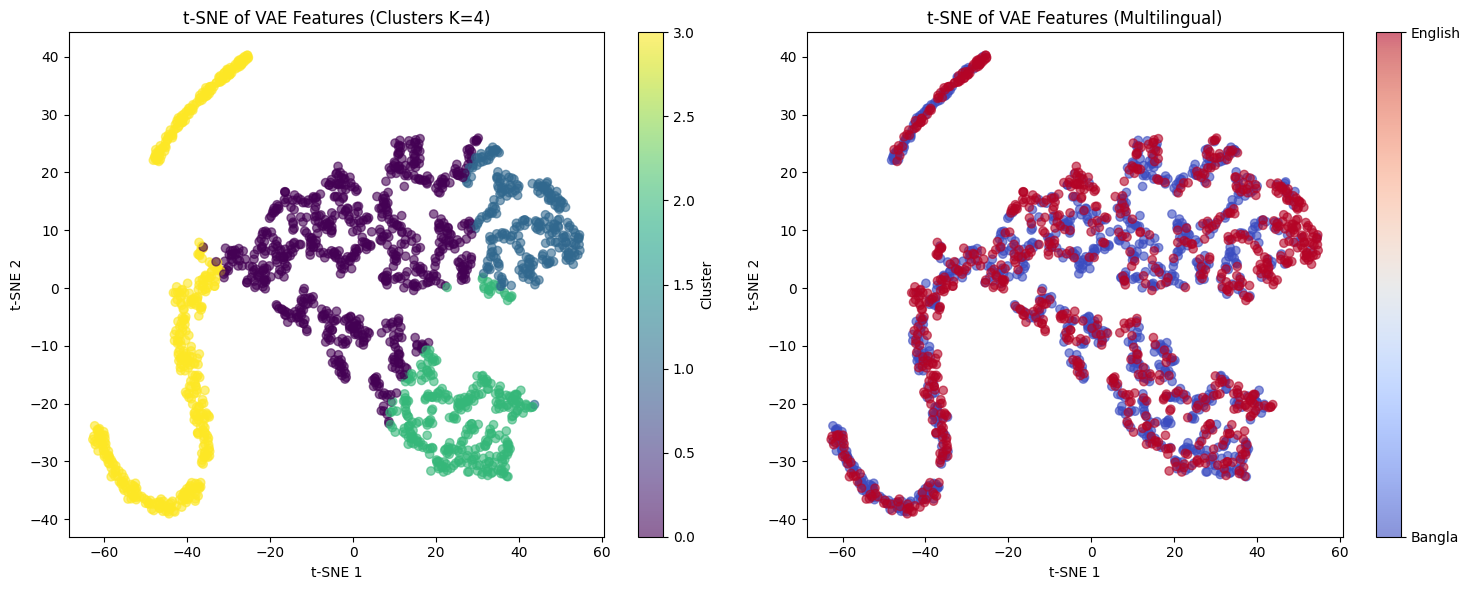

Visualization saved to f:\BRACU\Semester 12 Final\CSE425\FInal_project\results\tsne_visualization_simplified.png


In [17]:
print("\nGenerating t-SNE visualizations...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(latent_features)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Features (Colored by Clusters)
scatter1 = axes[0].scatter(tsne_results[:, 0], tsne_results[:, 1], c=vae_clusters, cmap='viridis', alpha=0.6)
axes[0].set_title(f't-SNE of VAE Features (Clusters K={best_k})')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Multilingual (Colored by Language)
# map language to colors: 0=Bangla, 1=English usually
languages = metadata['language'].map({'bn': 0, 'en': 1}).values
scatter2 = axes[1].scatter(tsne_results[:, 0], tsne_results[:, 1], c=languages, cmap='coolwarm', alpha=0.6)
axes[1].set_title('t-SNE of VAE Features (Multilingual)')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
cbar = plt.colorbar(scatter2, ax=axes[1], ticks=[0, 1])
cbar.ax.set_yticklabels(['Bangla', 'English'])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'tsne_visualization_simplified.png'))
plt.show()
print(f"Visualization saved to {os.path.join(RESULTS_PATH, 'tsne_visualization_simplified.png')}")